In [1]:
import numpy as np
import time
import cv2 
import torch 
from enum import Enum
import os

In [2]:
class ModelType(Enum): 
    DPT_LARGE = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
    DPT_Hybrid = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
    MIDAS_SMALL = "MiDaS_small" # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

    

In [8]:
class Midas():
    def __init__(self, modelType:ModelType=ModelType.DPT_LARGE):
            
        # self.midas = torch.hub.load("isl-org/MiDaS", modelType.value)
        self.midas = torch.hub.load("isl-org/MiDaS", "DPT_SwinV2_T_256")
        print(f'Loaded model')
        self.modelType = modelType
        self.THRESH = 0
        
        if torch.cuda.is_available():
            self.device = torch.device('cuda')
            print('Using CUDA')
        else:
            print('Using CPU')
            self.device = torch.device('cpu')
    
        self.midas.to(self.device)
        self.midas.eval()
        
        midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
        if self.modelType.value == "DPT_Large":
            self.transform = midas_transforms.dpt_transform
            self.THRESH = 26
        elif self.modelType.value == "DPT_Hybrid":
            self.transform = midas_transforms.dpt_transform
            self.THRESH = 1900
        else:
            self.transform = midas_transforms.small_transform
            self.THRESH = 850
        print('Loaded Transform')
        
        
    def predict(self, frame):
        t1 = time.time()
        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        input_batch = self.transform(img).to(self.device)
        t2 = time.time()
        with torch.no_grad():
            prediction = self.midas(input_batch)
            prediction = torch.nn.functional.interpolate(
                prediction.unsqueeze(1),
                size=img.shape[:2],
                mode="bicubic",
                align_corners=False,
            ).squeeze()
        depthMap = prediction.cpu().numpy()
        t3 = time.time()
        print(t3-t2, t2-t1)
        return depthMap

In [10]:
torch.hub.list("isl-org/MiDaS")

Using cache found in /home/bhavesh/.cache/torch/hub/isl-org_MiDaS_master


['DPTDepthModel',
 'DPT_BEiT_B_384',
 'DPT_BEiT_L_384',
 'DPT_BEiT_L_512',
 'DPT_Hybrid',
 'DPT_Large',
 'DPT_LeViT_224',
 'DPT_Next_ViT_L_384',
 'DPT_SwinV2_B_384',
 'DPT_SwinV2_L_384',
 'DPT_SwinV2_T_256',
 'DPT_Swin_L_384',
 'MiDaS',
 'MiDaS_small',
 'MidasNet',
 'MidasNet_small',
 'transforms']

In [9]:
model = Midas()

Using cache found in /home/bhavesh/.cache/torch/hub/isl-org_MiDaS_master


RuntimeError: Error(s) in loading state_dict for DPTDepthModel:
	Missing key(s) in state_dict: "pretrained.model.layers.3.downsample.reduction.weight", "pretrained.model.layers.3.downsample.norm.weight", "pretrained.model.layers.3.downsample.norm.bias", "pretrained.model.head.fc.weight", "pretrained.model.head.fc.bias". 
	Unexpected key(s) in state_dict: "pretrained.model.layers.0.downsample.reduction.weight", "pretrained.model.layers.0.downsample.norm.weight", "pretrained.model.layers.0.downsample.norm.bias", "pretrained.model.layers.0.blocks.1.attn_mask", "pretrained.model.layers.1.blocks.1.attn_mask", "pretrained.model.head.weight", "pretrained.model.head.bias". 
	size mismatch for pretrained.model.layers.1.downsample.reduction.weight: copying a param with shape torch.Size([384, 768]) from checkpoint, the shape in current model is torch.Size([192, 384]).
	size mismatch for pretrained.model.layers.1.downsample.norm.weight: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for pretrained.model.layers.1.downsample.norm.bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for pretrained.model.layers.2.downsample.reduction.weight: copying a param with shape torch.Size([768, 1536]) from checkpoint, the shape in current model is torch.Size([384, 768]).
	size mismatch for pretrained.model.layers.2.downsample.norm.weight: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for pretrained.model.layers.2.downsample.norm.bias: copying a param with shape torch.Size([768]) from checkpoint, the shape in current model is torch.Size([384]).

(np.float64(-0.5), np.float64(1279.5), np.float64(959.5), np.float64(-0.5))

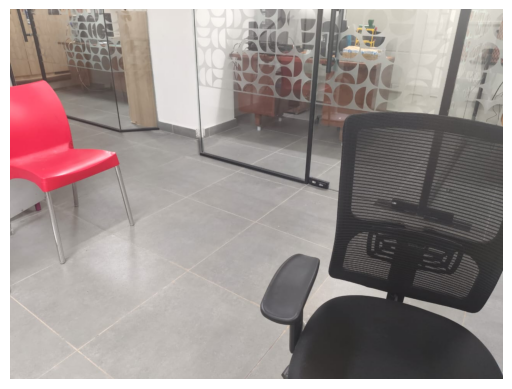

In [ ]:
import matplotlib.pyplot as plt

image_path = r"/home/bhavesh/pathpal/depthmap/test_image2.jpg"
image = cv2.imread(image_path)
# print(image)
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.axis('off')

In [ ]:
dmap = model.predict(image)

0.20364642143249512 0.017058849334716797


(np.float64(-0.5), np.float64(1279.5), np.float64(959.5), np.float64(-0.5))

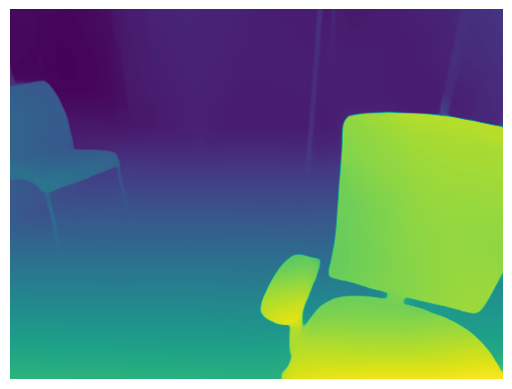

In [ ]:
depthMap = cv2.normalize(dmap, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
depthMap_rgb = cv2.applyColorMap(depthMap, cv2.COLORMAP_INFERNO)
plt.imshow(dmap)
plt.axis('off')